# Protein dihedral angle analysis

We look at backbone dihedral angles and generate Ramachandran and Janin plots.

The methods and examples shown here are only applicable to Universes where protein residue names have standard names, i.e. the backbone is comprised of --N--CA--C--N--CA-- atoms.



**Last executed:** Feb 06, 2020 with MDAnalysis 0.20.1

**Last updated:** February 2020

**Minimum version of MDAnalysis:** 0.19.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests

**Optional packages for visualisation:**

* [matplotlib](https://matplotlib.org)

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import GRO, XTC
from MDAnalysis.analysis import dihedrals
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)

In [2]:
u = mda.Universe(GRO, XTC)
protein = u.select_atoms('protein')
print('There are {} residues in the protein'.format(len(protein.residues)))

There are 214 residues in the protein


## Selecting dihedral atom groups

Proteins have canonical dihedral angles defined on the backbone atoms. $\phi$ (phi), $\psi$ (psi) and $\omega$ (omega) are backbone angles. The side-chain dihedral angles are called $\chi_n$ (chi-$n$), and can vary in number.

<center>
<div style="width: 250px; text-align: center;">
    
![dihedral angles in proteins](../../images/dihedrals.png)

</div>
</center>


MDAnalysis allows you to directly select the atoms involved in the $\phi$, $\psi$, $\omega$, and $\chi_1$ angles, provided that your protein atoms have standard names. If MDAnalysis cannot find atoms matching the names that it expects, it will return `None`. You can see below that `phi_selection()` returns an ordered AtomGroup of the atoms in the $\phi$ angle of a residue if they can be found, and `None` if not.

In [3]:
for res in u.residues[210:220]:
    phi = res.phi_selection()
    if phi is None:
        names = None
    else:
        names = phi.names
    print('{}: {} '.format(res.resname, names))

LYS: ['C' 'N' 'CA' 'C'] 
ILE: ['C' 'N' 'CA' 'C'] 
LEU: ['C' 'N' 'CA' 'C'] 
GLY: ['C' 'N' 'CA' 'C'] 
SOL: None 
SOL: None 
SOL: None 
SOL: None 
SOL: None 
SOL: None 


Similar functions exist for the other angles:

 - $\psi$ angle (`Residue.psi_selection`)
 
 - $\omega$ angle (`Residue.omega_selection`)
 
 - $\chi_1$ angle (`Residue.chi1_selection`)

## Calculating dihedral angles

Dihedral angles can be calculated directly from the AtomGroup, by converting it to a `Dihedral` object.

In [4]:
omegas = [res.omega_selection() for res in protein.residues[5:10]]
omegas[0].dihedral.value()

-169.78220560918737

The `analysis.dihedrals.Dihedral` class can be used to rapidly calculate dihedrals for AtomGroups over the entire trajectory.

In [5]:
dihs = dihedrals.Dihedral(omegas).run();

The angles are saved in `dihs.angles`, in an array with the shape (`n_frames`, `n_atomgroups`).

In [6]:
dihs.angles.shape

(10, 5)

### Plotting

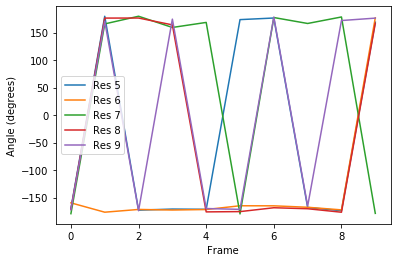

In [7]:
labels = ['Res {}'.format(n) for n in np.arange(5, 10)]
for ang, label in zip(dihs.angles.T, labels):
    plt.plot(ang, label=label)
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.legend()

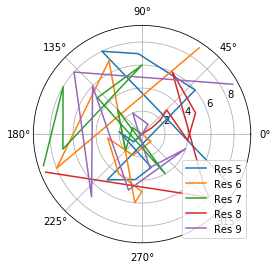

In [8]:
fig_polar = plt.figure()
ax_polar = fig_polar.add_subplot(111, projection='polar')
frames = np.arange(10)
for res, label in zip(dihs.angles.T, labels):
    c = ax_polar.plot(res, frames, label=label)
plt.legend();

## Ramachandran analysis

The `Ramachandran` class calculates the $\phi$ and $\psi$ angles of the selected residues over the course of the trajectory, again saving it into `.angles`. If residues are given that do not contain a $\phi$ and $\psi$ angle, they are omitted from the results. For example, the angles returned are from every residue in the protein *except* the first and last, for which a $\phi$ angle and a $\psi$ angle do not exist, respectively.

The returned `angles` are in the shape (`n_frames`, `n_residues`, 2) where the last dimension holds the $\phi$ and $\psi$ angle.

In [9]:
rama = dihedrals.Ramachandran(protein).run()
print(rama.angles.shape)

(10, 212, 2)


You can plot this yourself, but `Ramachandran.plot()` is a convenience method that plots the data from each time step onto a standard Ramachandran plot. You can call it with no arguments; any keyword arguments that you give (except `ax` and `ref`) will be passed to `matplotlib.axes.Axes.scatter` to modify your plot.

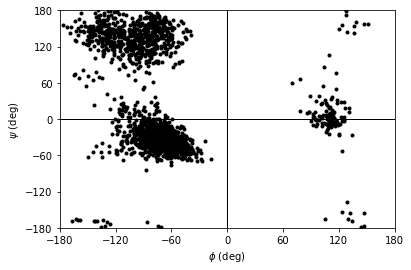

In [10]:
rama.plot(color='black', marker='.')

If you set `ref=True`, your data will be plotted with areas that show the allowed (dark blue) and marginally allowed (lighter blue) regions. 

<div class="alert alert-info">
    
**Note**

These regions are computed from a reference set of 500 PDB files from (<a data-cite="lovell_structure_2003" href="https://doi.org/10.1002/prot.10286">Lovell *et al.*, 2003</a>). The allowed region includes 90% data points, while the marginally allowed region includes 99% data points.

</div>

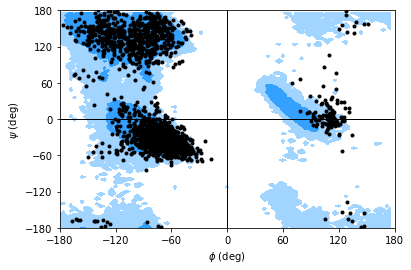

In [11]:
rama.plot(color='black', marker='.', ref=True)

## Janin analysis

The `Janin` class works similarly to the `Ramachandran` analysis, but looks at the $\chi_1$ and $\chi_2$ angles instead. It therefore ignores all residues without a long enough side-chain, such as alanine, cysteine, and so on.

Again, the returned `angles` are in the shape (`n_frames`, `n_residues`, 2) where the last dimension holds the $\chi_1$ and $\chi_2$ angle. We can see that only about half of the residues in AdK have side-chains long enough for this analysis.

In [12]:
janin = dihedrals.Janin(protein).run()
print(janin.angles.shape)

(10, 129, 2)


The `Janin` class also contains a `plot()` method.

<div class="alert alert-info">
    
**Note**

The reference regions here are also computed from the reference set of 500 PDB files from (<a data-cite="lovell_structure_2003" href="https://doi.org/10.1002/prot.10286">Lovell *et al.*, 2003</a>) (the allowed region includes 90% data points, while the marginally allowed region includes 98% data points). Information about general Janin regions is from (<a data-cite="janin_conformation_1978" href="https://doi.org/10.1016/0022-2836(78)90408-4">Janin *et al.*, 1978</a>). 

</div>

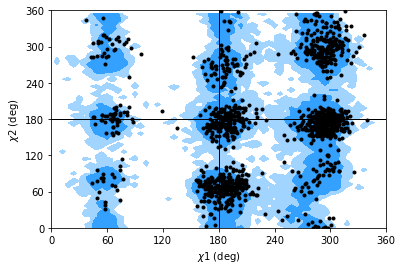

In [13]:
janin.plot(ref=True, marker='.', color='black')

## References

[1] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[2] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[3] Joël Janin, Shoshanna Wodak, Michael Levitt, and Bernard Maigret.
Conformation of amino acid side-chains in proteins.
<em>Journal of Molecular Biology</em>, 125(3):357 – 386, 1978.
00874.
URL: <a href="http://www.sciencedirect.com/science/article/pii/0022283678904084">http://www.sciencedirect.com/science/article/pii/0022283678904084</a>, <a href="https://doi.org/10.1016/0022-2836(78)90408-4">doi:10.1016/0022-2836(78)90408-4</a>.

[4] Simon&nbsp;C. Lovell, Ian&nbsp;W. Davis, W.&nbsp;Bryan Arendall, Paul I.&nbsp;W. de&nbsp;Bakker, J.&nbsp;Michael Word, Michael&nbsp;G. Prisant, Jane&nbsp;S. Richardson, and David&nbsp;C. Richardson.
Structure validation by <span class="bibtex-protected">Cα</span> geometry: ϕ,ψ and <span class="bibtex-protected">Cβ</span> deviation.
<em>Proteins: Structure, Function, and Bioinformatics</em>, 50(3):437–450, January 2003.
03997.
URL: <a href="http://doi.wiley.com/10.1002/prot.10286">http://doi.wiley.com/10.1002/prot.10286</a>, <a href="https://doi.org/10.1002/prot.10286">doi:10.1002/prot.10286</a>.

[5] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.